In [8]:
import torch
import tsensor
W = torch.rand(10,20)
b = torch.rand(10,1)
X = torch.rand(500,10)
with tsensor.explain(savefig='/tmp/mm.svg'):
    Y = W @ X.T + b

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x20 and 10x500)
Cause: @ on tensor operand W w/shape [10, 20] and operand X.T w/shape [10, 500]

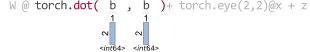

RuntimeError: 1D tensors expected, but got 2D and 2D tensors
Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]

In [1]:
import torch
import tsensor
import sys

W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])
# z + z + W @ z
# W @ z
#torch.dot(b, 3)

with tsensor.clarify():
    W @ torch.dot(b,b)+ torch.eye(2,2)@x + z
# W[33, 33] = 3
b = torch.abs( W @ b + x )

In [4]:
with tsensor.clarify():
    W @ torch.dot(b,b)+ torch.eye(2,2)@x + z

RuntimeError: 1D tensors expected, got 2D, 2D tensors at /tmp/pip-req-build-as628lz5/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83
Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]

## Graphviz

In [8]:
p = tsensor.parse.PyExprParser("b = W @ h + torch.abs(x) *h.dot(h)")
print(p.tokens)
root = p.parse()
root

[<NAME:b>, <EQUAL:=>, <NAME:W>, <AT:@>, <NAME:h>, <PLUS:+>, <NAME:torch>, <DOT:.>, <NAME:abs>, <LPAR:(>, <NAME:x>, <RPAR:)>, <STAR:*>, <NAME:h>, <DOT:.>, <NAME:dot>, <LPAR:(>, <NAME:h>, <RPAR:)>, <ENDMARKER:>]


Assign(lhs=b,rhs=BinaryOp(op=<PLUS:+>,lhs=BinaryOp(op=<AT:@>,lhs=W,rhs=h),rhs=BinaryOp(op=<STAR:*>,lhs=Call(func=Member(obj=torch,member=abs),args=[x]),rhs=Call(func=Member(obj=h,member=dot),args=[h]))))

In [9]:
frame = sys._getframe()
result = root.eval(frame)
result

tensor([[25, 31],
        [30, 36]])

In [7]:
def postorder(t):
    nodes = []
    _postorder(t, nodes)
    return nodes
def _postorder(t, nodes):
    if t is None:
        return
    for sub in t.kids:
        _postorder(sub, nodes)
    nodes.append(t)

In [ ]:
def leaves(t):
    nodes = []
    _leaves(t, nodes)
    return nodes
def _leaves(t, nodes):
    if t is None:
        return
    if len(t.kids)==0:
        nodes.append(t)
        return
    for sub in t.kids:
        _leaves(sub, nodes)

In [ ]:
nodes = postorder(root)
atoms = leaves(root)
atoms

In [ ]:
# map tokens to nodes
tok2node = {}
for nd in atoms:
    tok2node[nd.token] = nd

In [ ]:
def walk(t, pre=lambda x:None, post=lambda x:None):
    if t is None:
        return
    pre(t)
    for sub in t.kids:
        walk(sub, pre, post)
    post(t)

In [ ]:
import graphviz

s = """
digraph G {
    nodesep=.1;
    ranksep=.3;
    rankdir=BT;
    ordering=out; # keep order of leaves
    node [penwidth="0.5", shape=plaintext, width=.1, height=.1];
"""

nodesS = set(nodes)
atomsS = set(atoms)
ops = nodesS.difference(atomsS)

# s += f'{{ rank=same;'
# for a in atoms:
#     s += f' node{id(tok2node[a.token])};'
# s += '}\n'

s += f'{{ rank=same;'
for t in p.tokens:
    if t.type!=tsensor.ENDMARKER:
        x = tok2node[t] if t in tok2node else t
        shape = ""
        sh = tsensor._shape(x.value)
        if x in atomsS and sh is not None:
            shape = "shape=box, fixedsize=shape "
            if len(sh)==1:
                shape += f"width={.15}, height={sh[0]/6.66}"
            elif len(sh)==2:
                shape += f"width={sh[1]/6.66}, height={sh[0]/6.66}"
#         print(sh, shape)
        s += f'leaf{id(x)} [{shape} label=<<font face="Consolas" color="#444443" point-size="9">{t.value}</font>>]\n'
s += '}\n'

# for nd in ops:
#     s += f'leaf{id(nd)} [label=<<font face="Consolas" color="#444443" point-size="9">{str(nd)}</font>>]'

for nd in nodes:
    if nd in ops:
        text = str(nd)
#         if isinstance(nd, tsensor.Atom):
#             text = str(nd)
#         else:
#             text = nd.__class__.__name__
#         text = str(nd)#+"\n"+str(nd.value)
#         text = " "
        shape = ""
        sh = tsensor._shape(nd.value)
        if sh is not None:
            shape = "shape=box, fixedsize=shape "
            if len(sh)==1:
                shape += f"width={.15}, height={sh[0]/6.66}"
            elif len(sh)==2:
                shape += f"width={sh[1]/6.66}, height={sh[0]/6.66}"
        if sh is not None:
            text += "<br/>"+'x'.join(str(s) for s in sh)
#         else:
#             text += "="+str(nd.value)
        s += f'node{id(nd)} [{shape} label=<<font face="Consolas" color="#444443" point-size="9">{text}</font>>]\n'

# link leaves left to right
for i in range(len(p.tokens)-2):
    t = p.tokens[i]
    t2 = p.tokens[i+1]
    x = tok2node[t] if t in tok2node else t
    x2 = tok2node[t2] if t2 in tok2node else t2
    s += f'leaf{id(x)} -> leaf{id(x2)} [style=invis];\n'
    
for nd in nodes:
    kids = nd.kids
#     if isinstance(nd, tsensor.Call) and isinstance(nd.kids[0], tsensor.Member):
#         print('ignore', nd)
#         kids = kids[1:]
    for sub in kids:
        if sub in atomsS:
            s += f'node{id(nd)} -> leaf{id(sub)} [dir=back, penwidth="0.5", color="#444443", arrowsize=.4];\n'
        else:
            s += f'node{id(nd)} -> node{id(sub)} [dir=back, penwidth="0.5", color="#444443", arrowsize=.4];\n'
s += "}\n"
graphviz.Source(s)

In [ ]:
import graphviz

s = """
digraph G {
    nodesep=.1;
    ranksep=.3;
    rankdir=BT;
    ordering=out; # keep order of leaves
    node [penwidth="0.5", shape=plaintext, width=.1, height=.1];
"""

nodesS = set(nodes)
atomsS = set(atoms)
ops = nodesS.difference(atomsS)

s += f'{{ rank=same;'
for a in atoms:
    s += f'node{id(a)};'
s += '}\n'

for nd in nodes:
    if isinstance(nd, tsensor.Atom):
        text = str(nd)
    else:
        text = nd.__class__.__name__
    shape = ""
    sh = _shape(nd.value)
    if sh is not None:
        shape = "shape=box, fixedsize=shape "
        if len(sh)==1:
            shape += f"width={.15}, height={sh[0]/6.66}"
        elif len(sh)==2:
            shape += f"width={sh[1]/6.66}, height={sh[0]/6.66}"
    s += f'node{id(nd)} [{shape} label=<<font face="Consolas" color="#444443" point-size="9">{text}</font>>]\n'
    
for nd in nodes:
    kids = nd.kids
#     if isinstance(nd, tsensor.Call) and isinstance(nd.kids[0], tsensor.Member):
#         print('ignore', nd)
#         kids = kids[1:]
    for sub in kids:
        if sub in atomsS:
            s += f'node{id(nd)} -> node{id(sub)} [dir=back, penwidth="0.5", color="#444443", arrowsize=.4];'
        else:
            s += f'node{id(nd)} -> node{id(sub)} [dir=back, penwidth="0.5", color="#444443", arrowsize=.4];'
s += "}\n"
graphviz.Source(s)

In [ ]:
W = torch.tensor([[1, 2], [3, 4], [5, 6]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])
a = 3

x = torch.tensor([4, 5]).reshape(2, 1)
p = tsensor.PyExprParser("a = a")
p = tsensor.PyExprParser("b = W@b + torch.abs(x) + h.dot(h)")
p = tsensor.PyExprParser("b = W@b + h.dot(h)")
print(p.tokens)
root = p.parse()
nodes = postorder(root)
atoms = leaves(root)
# map tokens to nodes
tok2node = {}
for nd in atoms:
    tok2node[nd.token] = nd
frame = sys._getframe()
result = root.eval(frame)
result

In [ ]:
import graphviz

def matrix_html(nrows, ncols, label, fontsize=12, fontname="Consolas", dimfontsize=9, color="#cfe2d4"):
    isvec = ncols==None
    if isvec:
        sz = str(nrows)
        ncols=nrows
        nrows=1
    else:
        sz = f"{nrows}x{ncols}"
    w = ncols*20
    h = nrows*20
    if ncols==1:
        w = 15
    if nrows==1:
        h = 15
    html = f"""
    <table fixedsize="true" width="{w}" height="{h+2*fontsize*1.3}" BORDER="0" CELLPADDING="0" CELLBORDER="1" CELLSPACING="0">
    <tr>
    <td fixedsize="true" width="{w}" height="{fontsize*1.3}" cellspacing="0" cellpadding="0" border="0" valign="top" align="center">
    <font face="{fontname}" color="#444443" point-size="{dimfontsize}">{sz}</font>
    </td>
    </tr>
    <tr>    
    <td fixedsize="true" width="{w}" height="{h}" cellspacing="0" cellpadding="0" bgcolor="{color}" border="1" sides="ltbr" align="center">
    <font face="{fontname}" color="#444443" point-size="{fontsize}">{label}</font>
    </td>
    </tr>
    </table>"""
    return html

nodesS = set(nodes)
atomsS = set(atoms)
ops = nodesS.difference(atomsS)

s = """
digraph G {
    nodesep=.0;
    ranksep=.3;
    rankdir=BT;
    ordering=out; # keep order of leaves
"""

fontname="Consolas"
fontsize=12
spread = .2

s += f'{{ rank=same; '
for t in p.tokens:
    if t.type!=tsensor.ENDMARKER:
        x = tok2node[t] if t in tok2node else t
        shape = ""
        sh = tsensor._shape(x.value)
        label = f'<font face="{fontname}" color="#444443" point-size="{fontsize}">{t.value}</font>'
        matrixcolor="#cfe2d4"
        vectorcolor="#fefecd"
        if x in atomsS and sh is not None:
            if len(sh)==1:
                label = matrix_html(sh[0],None,t.value,fontname=fontname,fontsize=fontsize,color=vectorcolor)
            elif len(sh)==2:
                label = matrix_html(sh[0],sh[1],t.value,fontname=fontname,fontsize=fontsize,color=matrixcolor)
        # margin/width don't seem to do anything for shape=plain
        if t.type==tsensor.DOT:
            spread=.1
        if t.type==tsensor.EQUAL:
            spread=.25
        if t.type in tsensor.ADDOP:
            spread=.5
        if t.type in tsensor.MULOP:
            spread=.2
        s += f'leaf{id(x)} [shape=box penwidth=0 margin=.001 width={spread} label=<{label}>]\n'
s += '}\n'

s += "}\n"
# print(s)
graphviz.Source(s)

In [ ]:
s = """
digraph foo {
    rankdir=TB
    subgraph {
        node1;
    }
    subgraph {
        node2;
    }
    node1 -> node2
}
"""
display(graphviz.Source(s))
display(graphviz.Source(s))

## Get string size in matplotlib

In [ ]:
import matplotlib
import matplotlib.patches as patches
from matplotlib import pyplot as plt
def textdim(s, fontsize=11):
    fig, ax = plt.subplots(1,1)
    t = ax.text(0, 0, s, bbox={'lw':0}, fontsize=fontsize)
    plt.savefig("/tmp/junk")
    plt.close()
    bb = t.get_bbox_patch()
    w, h = bb.get_width(), bb.get_height()
    return w, h

In [ ]:
textdim("test of foO", fontsize=11)

In [ ]:
import numpy as np
a = [[1,2,3],[3,4,5]]
objviz(a)

In [ ]:
from lolviz import *
print(objviz(a).source)

In [ ]:
s = """
digraph G {
    ranksep=0;
    rankdir=BT;
    ordering=out; # keep order of leaves
    node1 [shape=plain, space="0.0", margin="0.01",label=<
<table BORDER="0" CELLPADDING="0" CELLBORDER="1" CELLSPACING="0">
<tr>
<td  width="100" height="12" cellspacing="0" cellpadding="0" border="1" sides="b" valign="top" align="center">100x200</td>
</tr>
<tr>
<td  width="100" height="88" cellspacing="0" cellpadding="0" border="1" sides="lbr" align="center">self.W</td>
</tr>
</table>
    >]
}
"""
graphviz.Source(s)

## CSS (yuck)

In [ ]:
from IPython.core.display import display, HTML
h = """
<h6 style="color: Green; position:absolute; top: 20vh; left: 25vw; height: auto; margin: auto;">Actief</h6>
<table>
<tr>
    <td>b = torch.abs( W @ b +</td>
    <td><div style="width:100px;height:150px;border:1px solid #000;">
    <table style="width:100px;height:150px" border='0' cellborder='0' cellpadding="0" cellspacing="0">
           <tr>
               <td height="50%" width="33%"></td>
               <td width="33%" cellpadding="0" cellspacing="0" align=center valign=top>40</td><td width="33%"></td>
           </tr>
           <tr>
               <td width="33%" cellpadding="0" cellspacing="0">100</td>
               <td width="33%" cellpadding="0" cellspacing="0" align="center">self.W</td>
               <td width="33%"></td>
           </tr>
         </table>
    </div>
    </td>
    <td>)</td>
</tr>
"""
t = HTML(h)
t

In [ ]:
def matrix(nrows,ncols,text,dim_fontsize=9,fontsize=12):
    h = f"""
    <div style="position:relative; width:{ncols}px;height:{nrows*1.2}px; padding:0px">
     <div style="position:relative; width:{ncols}px;height:{nrows}px;border:1px solid #000; padding:0px">
      <div style="position:absolute; width:{ncols}px; top: -3px; text-align:center; font-size:{dim_fontsize}px">
        {ncols}
      </div>
      <div style="position:absolute; top: 40%; left: -3px; transform: rotate(-90deg); font-size:{dim_fontsize}px">
        {nrows}
      </div>
     </div>
     <div style="position:absolute; width:{ncols}px; bottom: 5px; text-align:center; font-size:{fontsize}px">
        {text}
     </div>
    </div>
    """
    sp = f"""
    <div style="position:relative; width:{ncols}px;height:{nrows*1.2}px; padding:0px">
     <span style="position:relative; width:{ncols}px;height:{nrows}px;border:1px solid #000; padding:0px">
      <span style="position:absolute; width:{ncols}px; top: -3px; text-align:center; font-size:{dim_fontsize}px">
        {ncols}
      </span>
      <span style="position:absolute; top: 40%; left: -3px; transform: rotate(-90deg); font-size:{dim_fontsize}px">
        {nrows}
      </span>
     </span>
     <span style="position:absolute; width:{ncols}px; bottom: 5px; text-align:center; font-size:{fontsize}px">
        {text}
     </span>
    </div>
    """

    return sp

m = matrix(120,20,"self.W")
m = f"torch.relu({m})"
HTML(m)